# CBED Simulations

In [244]:
%load_ext autoreload
%autoreload 2
import numpy as np

from ase.build import mx2
from ase.io import read
from ase.visualize import view

from tensorwaves.waves import ProbeWaves
from tensorwaves.potentials import Potential
from tensorwaves.plotutils import plot_atoms
from tensorwaves.analyse import fwhm

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We import or building the atomic model of the sample. Remember that the Fourier space sampling of the CBED pattern will be inversely proportional to the size of the simulation cell. The size of the cell can be increased by either repeating it, or increasing the vacuum around structure.

In [249]:
atoms = read('../data/mos2.traj')

atoms *= (4,4,1)                      # uncomment to repeat unit cell
# atoms.center(vacuum=5, axis=(0,1))  # uncomment to increase vacuum

cell = np.diag(atoms.get_cell())
potential = Potential(atoms)

We choose the probe position. In this case we have put the probe directly on top of atom # 10. The id of each atom can be inspected using the ASE viewer.

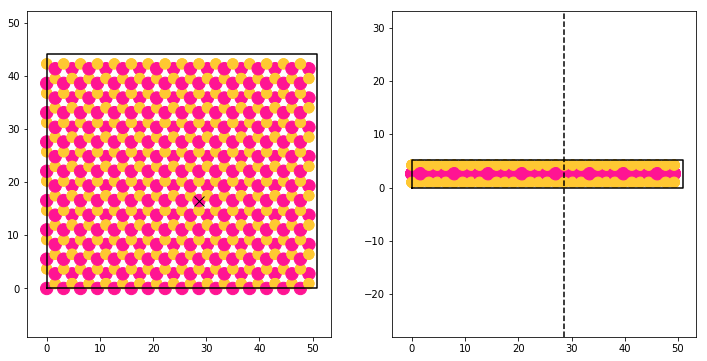

In [253]:
# view(atoms)                                    # uncomment to view atoms in ASE viewer
# probe_position = [5.,5.]                       # place probe at coordinate
probe_position = atoms.get_positions()[450, :2]  # place on atom with id 10

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
plot_atoms(atoms, plane='xy', ax=ax1)
ax1.plot(probe_position[0], probe_position[1], 'kx', markersize=10)
plot_atoms(atoms, plane='xz', ax=ax2)
ax2.axvline(probe_position[0], color='k', linestyle='--')

We build the incmoing probe wave function from a set of microscope parameters. We also set the real space sampling, which will define the largest spatial frequency present in the CBED pattern.

The Full Width at Half Maximum of the probe: 1.4590544443966353


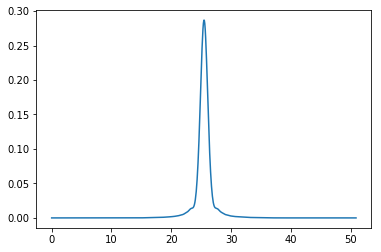

In [254]:
energy = 80e3        # acceleration voltage [eV]
aperture = .03       # convergence semiangle of the aperture [mrad]
defocus = 10         # defocus [Å]
Cs = -5e5            # spherical aberration [Å]
focal_spread = 40    # focal spread of beam [Å]
sampling = .075      # real space sampling [Å / pixel]

probe = ProbeWaves(energy=energy, 
                   extent=potential.extent, 
                   sampling=sampling,
                   aperture_cutoff=aperture, 
                   defocus=defocus,
                   Cs=Cs,
                   focal_spread=focal_spread)

probe.show_profile()

print('The Full Width at Half Maximum of the probe:', probe.get_fwhm())

The probe is propagated through the sample to get the probe at the exit plane of the atomic potential. The variable `pattern` is a numpy array containing the CBED pattern, i.e. the absolute square of the fourier transform of the exit probe. 

In [255]:
exit_probe = probe.multislice(potential)

pattern = exit_probe.diffractogram().numpy()[0]

Multislice [||||||||||||||||||||||||||||||||||||||||||||||||||] 11/11 


The CBED pattern is plotted on a logarithmic scale given by `np.log(1 + log_scale * pattern)`. The variable `log_scale` controls the appearance of the pattern, by increasing this variable the low intensity pixels are amplified.

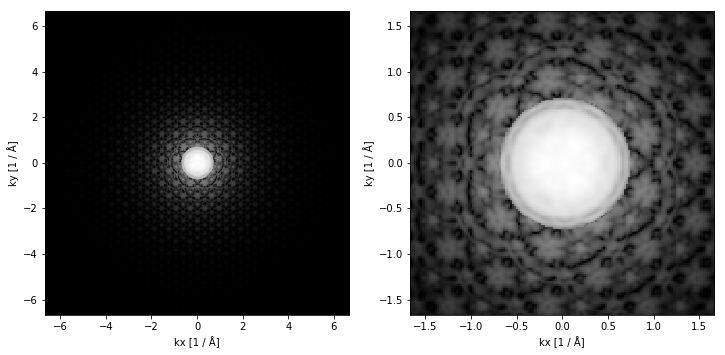

In [257]:
log_scale = .2
zoom = 4

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,12))
ax1.imshow(np.log(1 + log_scale * pattern).T, extent=probe.grid.fftfreq_range(), cmap='gray')
ax1.set_xlabel('kx [1 / Å]')
ax1.set_ylabel('ky [1 / Å]')

crop = ((1 - 1 / zoom) * np.array(pattern.shape) / 2).astype(int)
ax2.imshow(np.log(1 + log_scale * pattern)[crop[0] : -crop[0] - 1, crop[1] : -crop[1] -1], 
           extent=probe.grid.fftfreq_range()/zoom, cmap='gray')

ax2.set_xlabel('kx [1 / Å]')
ax2.set_ylabel('ky [1 / Å]');